
# sinc(x, y)

$
1-\; we'll\;draw\;the \;function
\\2-\; simulating\; it\; using\; ANFIS
\\3- simulating\; it \;using\; NN
$
$$
z = \text{sinc}(x,y) = \frac{\sin(x)\sin(y)}{xy}
$$



$$
interestingly\;the\;Neural\;Networks\;gets\;better\;answer\;!!
$$

# Part 1

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

<IPython.core.display.Javascript object>


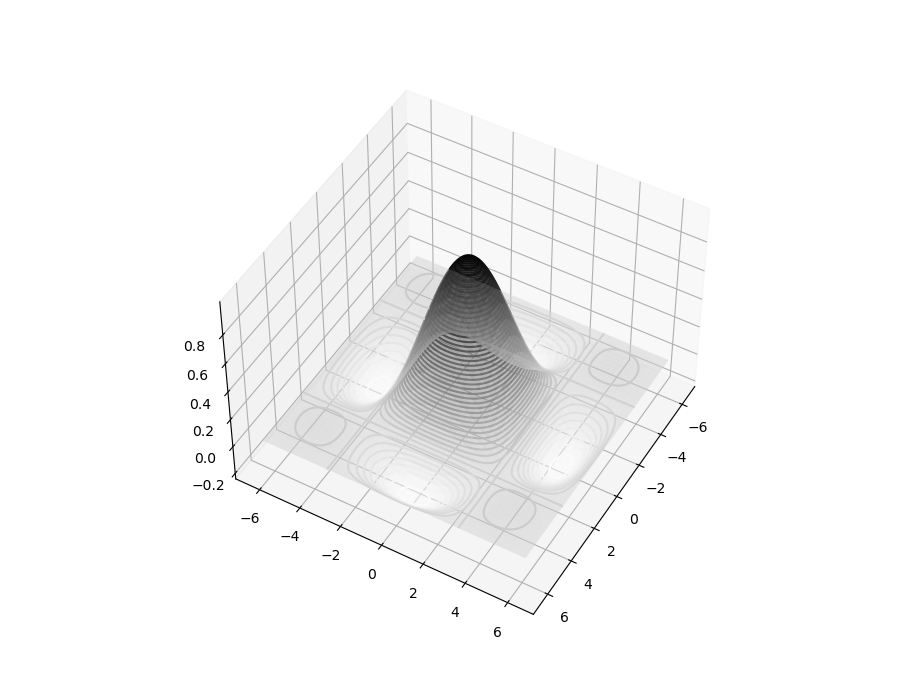

In [2]:
%matplotlib notebook

fig = plt.figure(figsize = (9,7))
ax = plt.axes(projection='3d')

n = 300
X = np.linspace(-2*np.pi,2*np.pi,n)
Y = np.linspace(-2*np.pi,2*np.pi,n)
XX,YY = np.meshgrid(X,Y)
ZZ = np.sin(XX)*np.sin(YY)/(XX*YY)
ax.contour3D(XX,YY,ZZ,50,cmap='binary')
ax.plot_surface(XX,YY,ZZ,alpha=0.5,cmap='binary')
ax.view_init(30,15)
plt.show()

# Part 2

10000 was too much, I used 1000

In [3]:
class ANFIS(object):
    def __init__(self,):
        self.nb = 12
        self.eta = 0.1
        self.bsize = 10
        self.nepochs = 24
        self.mux = np.random.randn(self.nb)
        self.sigx = 2.0*abs(np.random.randn(self.nb))
        self.muy = np.random.randn(self.nb)
        self.sigy = 2.0*abs(np.random.randn(self.nb))
        self.a = np.random.randn(self.nb,self.nb)
        self.b = np.random.randn(self.nb,self.nb)
        self.c = np.random.randn(self.nb,self.nb)

    def f(self,xy):
        x,y = xy
        return self.a*x + self.b*y + self.c 

    def gauss(self,x,mu,sig):
        return np.exp(-((x-mu)/sig)**2/2)

    def w(self,xy):
        x,y = xy
        w = np.zeros((self.nb,self.nb))
        for i in range(self.nb):
            for j in range(self.nb):
                w[i,j] = self.gauss(x,self.mux[i],self.sigx[i]) * self.gauss(y,self.muy[j],self.sigy[j])
        return w

    def predict(self,xy):
        w = self.w(xy)
        wsum = np.sum(w)
        f = self.f(xy)
        zp = w * f / wsum
        zp = zp.sum()
        return zp

    def error(self,xy,z):
        zp = self.predict(xy)
        return 0.5*(zp-z)**2

    def gradient(self,xy,z):
        x,y = xy
        w = self.w(xy)
        wsum = np.sum(w)
        f = self.f(xy)
        zp = w * f / wsum
        zp = zp.sum()
        gEz = zp - z

        gEa = gEz*w*x
        gEb = gEz*w*y
        gEc = gEz*w

        gZw = (f-zp)/wsum
        gEmux = np.zeros(self.nb)
        gEmuy = np.zeros(self.nb)
        gEsigx = np.zeros(self.nb)
        gEsigy = np.zeros(self.nb)
        for i in range(self.nb):
            gEmux[i] = np.sum([gEz*gZw[i,j]*((x-self.mux[i])/self.sigx[i]**2)*w[i,j] for j in range(self.nb)])
            gEsigx[i] = np.sum([gEz*gZw[i,j]*((x-self.mux[i])**2/self.sigx[i]**3)*w[i,j] for j in range(self.nb)])
            gEmuy[i] = np.sum([gEz*gZw[j,i]*((x-self.muy[i])/self.sigy[i]**2)*w[j,i] for j in range(self.nb)])
            gEsigy[i] = np.sum([gEz*gZw[j,i]*((x-self.muy[i])**2/self.sigy[i]**3)*w[j,i] for j in range(self.nb)])
        
        return gEa,gEb,gEc,gEmux,gEsigx,gEmuy,gEsigy
        
    def data_loading(self,data_trn, data_tst):
        self.data_trn = data_trn
        self.data_tst = data_tst
    
    def GD(self,):
        n = self.data_trn.shape[0]
        for epoch in range(self.nepochs):
            np.random.shuffle(self.data_trn)
            for i in range(0,n,self.bsize):
                data_batch = self.data_trn[i:i+self.bsize]
                gEa,gEb,gEc,gEmux,gEsigx,gEmuy,gEsigy = 0.,0.,0.,0.,0.,0.,0.
                for xy,z in zip(data_batch[:,:2],data_batch[:,2]):
                    gEa_,gEb_,gEc_,gEmux_,gEsigx_,gEmuy_,gEsigy_ = self.gradient(xy,z)
                    gEa += gEa_
                    gEb += gEb_
                    gEc += gEc_
                    gEmux += gEmux_
                    gEsigx += gEsigx_
                    gEmuy += gEmuy_
                    gEsigy += gEsigy_

                self.a -= self.eta/data_batch.shape[0] * gEa
                self.b -= self.eta/data_batch.shape[0] * gEb
                self.c -= self.eta/data_batch.shape[0] * gEc

                self.mux -= self.eta/data_batch.shape[0] * gEmux
                self.muy -= self.eta/data_batch.shape[0] * gEmuy
                self.sigx -= self.eta/data_batch.shape[0] * gEsigx
                self.sigy -= self.eta/data_batch.shape[0] * gEsigy

            training_error = np.mean([self.error(i,j) for i,j in zip(self.data_trn[:,:2],self.data_trn[:,2])]).round(3)
            testing_error = np.mean([self.error(i,j) for i,j in zip(self.data_tst[:,:2],self.data_tst[:,2])]).round(3)
            print(f"\rEPOCH: {epoch+1} \t TRAINING ERROR: {training_error} \t TESTING ERROR: {testing_error}",end="")

            
            
            
n = 700

X = np.random.uniform(-2*np.pi,2*np.pi,n)
Y = np.random.uniform(-2*np.pi,2*np.pi,n)
Z = np.sin(X)*np.sin(Y)/(X*Y)
tdata = np.hstack((X.reshape((-1,1)),Y.reshape((-1,1)),Z.reshape((-1,1))))

n = 150
X = np.linspace(-2*np.pi,2*np.pi,n)
Y = np.linspace(-2*np.pi,2*np.pi,n)
XX,YY = np.meshgrid(X,Y)
ZZ = np.sin(XX)*np.sin(YY)/(XX*YY)
tsdata = np.hstack((XX.reshape((-1,1)),YY.reshape((-1,1)),ZZ.reshape((-1,1))))    
            
            
            

anfis = ANFIS()
anfis.data_loading(tdata, tsdata)
anfis.GD()

EPOCH: 24 	 TRAINING ERROR: 0.007 	 TESTING ERROR: 0.008

<IPython.core.display.Javascript object>


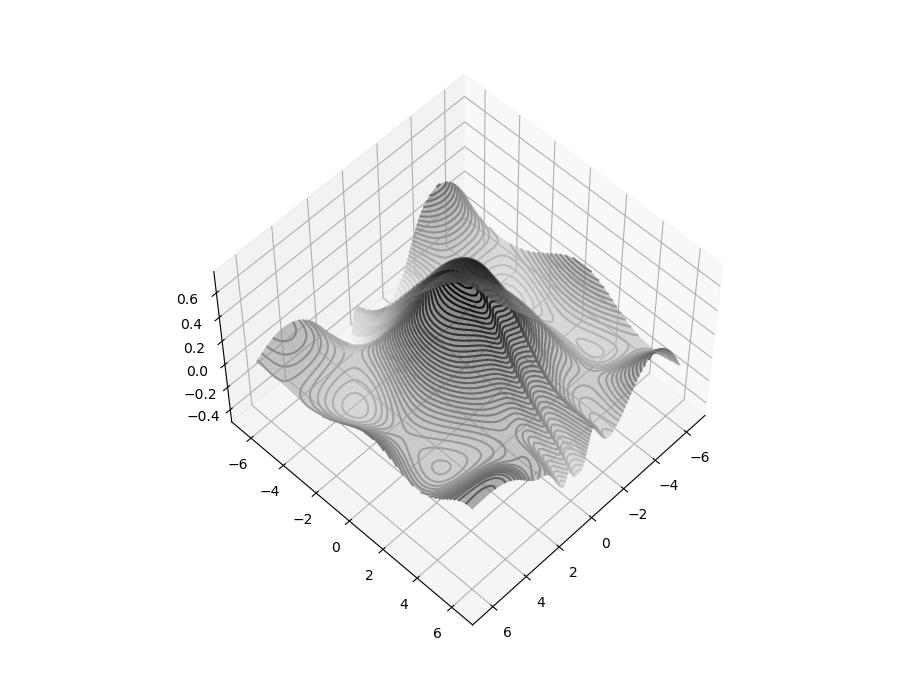

In [4]:

n = 100
X = np.linspace(-2*np.pi,2*np.pi,n)
Y = np.linspace(-2*np.pi,2*np.pi,n)
XX,YY = np.meshgrid(X,Y)
ZZp = np.zeros_like(XX)
for i in range(n):
    for j in range(n):
        ZZp[i,j] = anfis.predict((XX[i,j],YY[i,j]))

%matplotlib notebook

fig = plt.figure(figsize = (9,7))
ax = plt.axes(projection='3d')
ax.contour3D(XX,YY,ZZp,50,cmap='binary')
ax.plot_surface(XX,YY,ZZp,alpha=0.5,cmap='binary')
ax.view_init(30,15)
plt.show()

# Part 3

In [148]:
class NN(object):
    
    def __init__(self, d = 2, m = 3, p = 1, eta = 1e-1, num_steps = int(1e5)):
        self.d = d
        self.m = m
        self.p = p
        self.eta = eta = 1e-1  # step size (learning rate)
        self.num_steps = num_steps
        self.WS = [np.random.randn(self.d+1,self.m), np.random.randn(self.m+1,self.p)]
    
    def f1(self, x): return np.tanh(x)
    def df1(self, x): return 1 - np.power(np.tanh(x),2)
    def f2(self, x): return x
    def df2(self, x): return 1
    
    def aug(self, X):                                 #puts a 1 column in front of matrix
        n = len(X)
        X1 = np.ones((n,1))
        return np.hstack((X1,X))
    
    def predict(self, X):                       #the name suggests =)
        Z = self.f1( self.aug(X) @ self.WS[0])
        O = self.f2( self.aug(Z) @ self.WS[1])
        return O

    def update_pars(self, Y, X):
        Xt = self.aug(X)
        Z = self.f1(Xt @ self.WS[0])
        Zt = self.aug(Z)
        dZ = self.df1(Xt @ self.WS[0])
        O = self.f2(Zt @ self.WS[1])
        G2 = (O - Y)/len(Y)
        dW2 = Zt.T @ G2
        self.WS[1] -= self.eta * dW2
        G1 = (G2 @ self.WS[1][1:].T)*dZ
        dW1 = Xt.T @ G1
        self.WS[0] -= self.eta * dW1
   
    def train(self, Y, X):
        for i in range(self.num_steps):
            self.update_pars(Y, X)

In [149]:
nn = NN(m = 8)

In [152]:
y = tdata[:, 2].reshape((-1,1))

x = tdata[:, 0:2]

nn.train(y, x)

<IPython.core.display.Javascript object>


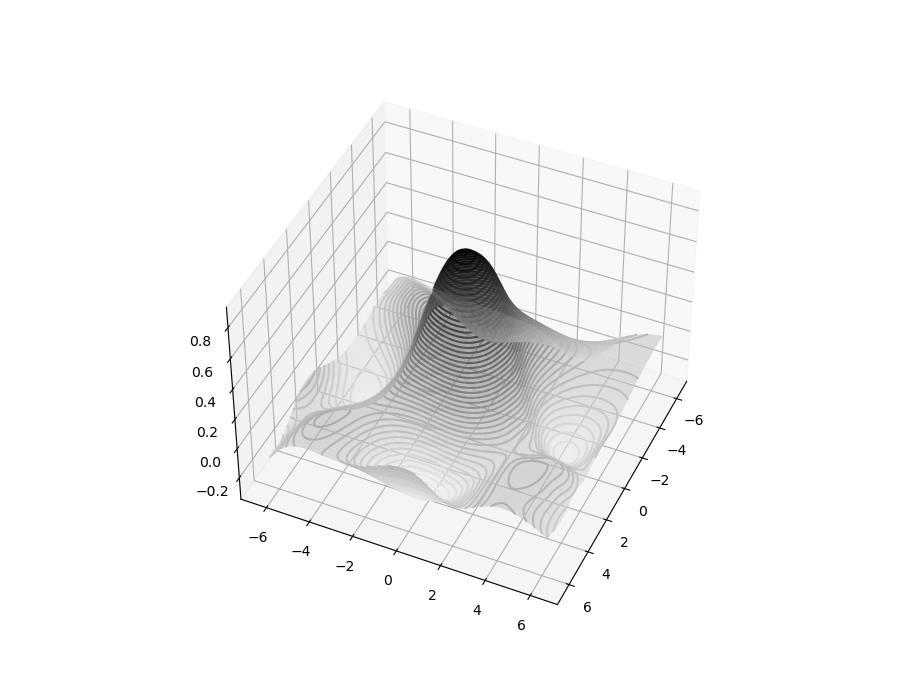

In [154]:
n = 100
X = np.linspace(-2*np.pi,2*np.pi,n)
Y = np.linspace(-2*np.pi,2*np.pi,n)
XX,YY = np.meshgrid(X,Y)
ZZp = np.zeros_like(XX)
for i in range(n):
    for j in range(n):
        p = np.array([[XX[i,j],YY[i,j]]])
        ZZp[i,j] = nn.predict(p)

%matplotlib notebook

fig = plt.figure(figsize = (9,7))
ax = plt.axes(projection='3d')
ax.contour3D(XX,YY,ZZp,50,cmap='binary')
ax.plot_surface(XX,YY,ZZp,alpha=0.5,cmap='binary')
ax.view_init(30,15)
plt.show()